# CMP466 Project: Coral Reef Bleaching Classification
*       Dataset Name: A Global Coral-Bleaching Database, 1980-2020

*       I. Data Cleaning and Preprocessing
*       II. Machine Learning Methods
*               a. Decision Tree Classifier

In [ ]:
#ALL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from collections import Counter

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier


### I. Cleaning & Preprocessing the Dataset

In [ ]:
dtype_options = {
    'Distance_to_Shore' : 'object',
    'Turbidity' : 'object',
    'Percent_Bleaching' : 'object'
}  # these features contain values that are either numerical or strings, so we need to change it to Object before proceeding

myfilepath = r'global_bleaching_environmental.csv'

In [ ]:
df = pd.read_csv(myfilepath, dtype = dtype_options)

In [ ]:
#display(df)

In [ ]:
#df.describe()       # data summary (original dataset without cleaning)

In [ ]:
#df.info()           # non-null count is equal to the number of records because the empty cells are labelled as 'nd', not as null or NaN (doesn't recognize it)

In [ ]:
#df.nunique()           # returns an int value representing the number of unique values (applied to all columns)

In [ ]:
#df.isnull()         # we're getting all 'False' because it doesn't recognize 'nd' as null

#### Identifying Columns/Records with 'nd'

In [ ]:
 # first, drop any record with no target

df_new1 = df[df['Percent_Bleaching'] != 'nd']
df_new1['Percent_Bleaching'].value_counts()

0        16607
5.5       1184
75         914
0.25       882
1          705
         ...  
5.32         1
5.28         1
5.27         1
5.23         1
97.22        1
Name: Percent_Bleaching, Length: 2271, dtype: int64

In [ ]:
df_new1.shape            # now, the dataset is composed of 34515 records with the number of columns unchanged

(34515, 62)

In [ ]:
# identify any columns with 'nd' occupying more than 10% of its rows

cols1 = df_new1.columns.values   # cols contains the columns names as a list
cols1_to_drop = []               # store columns to drop in this list
for c in cols1:                  # iterate through each value belonging to the columns and search for those columns with more than 10% of its rows as 'nd'
    ndCount = (df_new1[c] == 'nd').sum()
    if ndCount > 0.1 * df_new1.shape[0]:
        cols1_to_drop.append(c)
print(cols1_to_drop)            # Output: ['Reef_ID', 'Site_Name', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments']
                                # To check the values of Bleaching_Level --> df_new['Bleaching_Level'].value_counts()

['Reef_ID', 'Site_Name', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments']


In [ ]:
cols1_to_drop.extend(['SSTA_Mean', 'Data_Source', 'Country_Name', 'State_Island_Province_Name', 'City_Town_Name', 'Date', 'Date_Day', 'Date_Month', 'Date_Year', 'Site_ID'])
len(cols1_to_drop)    # we added irrelevant or completely zero columns to remove as well

18

In [ ]:
# now, drop the identified columns/features

df_new2 = df_new1.drop(columns = cols1_to_drop)
#display(df_new2)

In [ ]:
df_new2.shape                   # now, the dataset is composed of 34515 records and 54 columns (including target)

(34515, 44)

In [ ]:
df_new3 = df_new2.replace('nd', np.nan).dropna()       # remove any records with 'nd'
#df_new3

In [ ]:
#df_new3.replace('nd', np.nan).isnull().sum()      # checking that all columns now have no null values

#### Checking Collinearity

TODO:
* Go over all features and see which ones have mixed data types (find a way to check data types for individual vals of the column)
* We can follow the paper, where any features with a collinearity coefficient higher than 0.8 are dropped
*       Some features mentioned in the paper are TSA_DHW and wind speed
* Features Highly Correlated with Coral Bleaching (As Indicated in Paper):
*       SST, SSTA, Coral Depth, Longitude, Latitude      


In [ ]:
#df_new3.info()          # we want to check the data types for each column
                        # it seems that many columns are classified as 'object', where if you check the type of each value, it will give you string even if the type is float!

In [ ]:
# identify all columns of data type 'object'
object_columns = df_new3.select_dtypes(include = ['object'])
#object_columns.info()

In [ ]:
notFloat_cols = ['Ocean_Name', 'Realm_Name', 'Ecoregion_Name', 'Exposure']
float_cols = [col for col in object_columns if col not in notFloat_cols]
df_new4 = df_new3
df_new4[float_cols] = df_new3[float_cols].astype(float)
#df_new4.info()

In [ ]:
df_new4[notFloat_cols] = df_new4[notFloat_cols].astype('string')
#df_new4.info()

In [ ]:
#df_new4.corr(numeric_only = True)      # correlation matrix

In [ ]:
#sns.heatmap(df_new4.corr(numeric_only = True), cmap = 'RdBu')

#### Next Step is to Encode Features
*     Exposure -> ordinal (integer encoding)
*           df_new4['Exposure'].nunique() -> 3
*     Ocean Name -> nominal (one-hot encoding)
*     Other Names -> nominal (one-hot encoding)


In [ ]:
df_new5 = df_new4

In [ ]:
ordinal_encoder = OrdinalEncoder()
df_new5[['Exposure']] = ordinal_encoder.fit_transform(df_new5[['Exposure']])        # for reference: 0.0 is Exposed, 1.0 is Sheltered, 2.0 is Sometimes

In [ ]:
#oneHot_encoder = OneHotEncoder()
#encodedCols = ['Ocean_Name', 'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name', 'City_Town_Name']       # I'm assuming no need for 'Data_Source'???

#oneHot_encoder_result = oneHot_encoder.fit_transform(df_new5[encodedCols])
#df_new5 = df_new5.join( pd.DataFrame( oneHot_encoder_result.toarray(), columns = oneHot_encoder.categories_ ))    # DataFrame consists of the data and the columns
                                                                                                                  # Converting the resultant OHE matrix to an array and then to a dataframe
                                                                                                                  # oneHot_encoder.feature_names_in_ -> gives you only the feature name!!
                                                                                                                  # we want the categories -> onehot_enc.categories_
# ^^^ last line gives this error: ValueError: all arrays must be same length

In [ ]:
encodedCols = ['Ocean_Name', 'Ecoregion_Name', 'Realm_Name']       # 5 cols for Ocean, 8 for Realm, 100 for Ecoregeion
df_new6 = pd.get_dummies(df_new5, columns=encodedCols).astype(int)
#display(df_new6)

##### So far (as of df_new6) we have 32675 records, and 154 columns
42 features total + 1 label column\
113 of the cols are OHE for 3 features\
during model training we will feed 152 features (removing the sample ID)

##### Discretizing Target Percent Bleaching

In [ ]:
df_new6['Percent_Bleaching'].value_counts()

0     19111
1      2065
5      1563
2      1167
3       721
      ...  
94       10
79        9
97        7
84        6
99        2
Name: Percent_Bleaching, Length: 101, dtype: int64

#### Feature Selection Before Discretization

In [ ]:
#df_new9 = df_new6

#y = df_new9['Percent_Bleaching'].to_numpy()
#X = df_new9.drop(columns=['Sample_ID', 'Percent_Bleaching']).to_numpy()


#X_new = SelectPercentile(f_classif, percentile = 50).fit_transform(X, y)

#X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20, random_state=42)

#coral_DT = DecisionTreeClassifier()
#coral_DT.fit(X_train, y_train)

#print(coral_DT.score(X_train, y_train))
#print(coral_DT.score(X_test, y_test))

# Graph Discretized Bins vs Accuracy

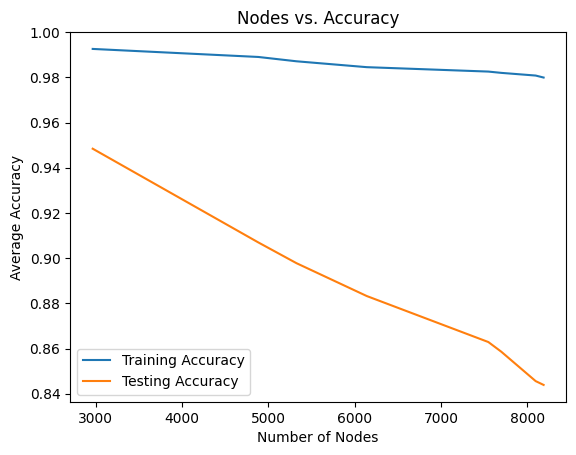

In [ ]:
train_acc = []
test_acc = []
node_count = []

binsList = list(range(2,10))
for n in binsList:
    kbd = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    df_new7 = df_new6 # make a copy

# The below is for when we want to mask the zeros
#    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#    mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#    discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#    df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1

    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching']
    df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']])
    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

    y = df_new7['Percent_Bleaching_Discretized'].to_numpy()
    X = df_new7.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    coralDT = DecisionTreeClassifier() #create the tree
    coralDT.fit(X_train, y_train) #train the tree
    train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
    test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
    node_count.append(coralDT.tree_.node_count) #retrieve the nodes used

plt.plot(node_count, train_acc, label='Training Accuracy')
plt.plot(node_count, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Average Accuracy')
plt.title('Nodes vs. Accuracy')
plt.legend()
plt.show()


#    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

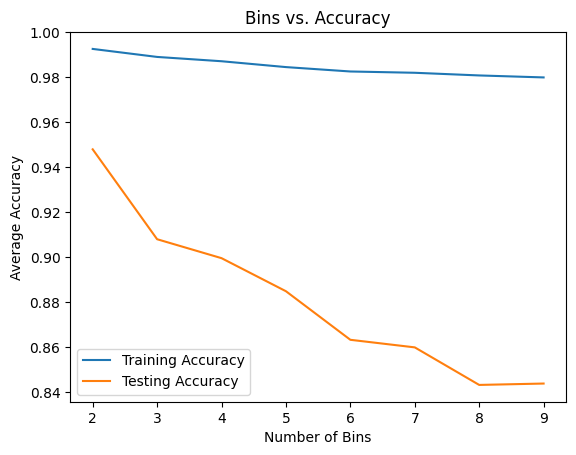

In [ ]:
train_acc = []
test_acc = []

binsList = list(range(2,10))
for n in binsList:
    kbd = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    df_new7 = df_new6 # make a copy

# The below is for when we want to mask the zeros
#    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#    mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#    discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#    df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1

    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching']
    df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']])
    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

    y = df_new7['Percent_Bleaching_Discretized'].to_numpy()
    X = df_new7.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    coralDT = DecisionTreeClassifier() #create the tree
    coralDT.fit(X_train, y_train) #train the tree
    train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
    test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming

plt.plot(binsList, train_acc, label='Training Accuracy')
plt.plot(binsList, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Bins')
plt.ylabel('Average Accuracy')
plt.title('Bins vs. Accuracy')
plt.legend()
plt.show()


# Discretization

In [ ]:
#kbd = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')   # K-means Discretization
                                                                        # Test to see which is the optimal number of bins
#df_new7 = df_new6 # make a copy
#df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1
#df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

In [ ]:
#df_new7['Percent_Bleaching_Discretized'].value_counts()

In [ ]:
#kbd.bin_edges_

# Discretize without Mask

In [ ]:
kbd = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')   # K-means Discretization
                                                                        # Test to see which is the optimal number of bins
df_new7 = df_new6 # make a copy

df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later

df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']]) # discretize the non-zeros
df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

,Percent_Bleaching,Percent_Bleaching_Discretized
0,50,1.0
1,50,1.0
2,50,1.0
3,50,1.0
4,50,1.0
...,...,...
35040,100,1.0
35041,100,1.0
35042,100,1.0
35043,100,1.0


In [ ]:
df_new7['Percent_Bleaching_Discretized'].value_counts()

0.0    29865
1.0     2810
Name: Percent_Bleaching_Discretized, dtype: int64

In [ ]:
kbd.bin_edges_

array([array([  0.       ,  31.5591283, 100.       ])], dtype=object)

# Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")

df_new10 = df_new7

y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0.0, 2810), (1.0, 2810)]


Undersampling Majority to be twice as large as minority

In [ ]:
# rus = RandomUnderSampler(random_state=0, sampling_strategy=0.3)

# df_new10 = df_new7

# y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
# X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

# X_undersampled, y_undersampled = rus.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))

Oversampling Minority to be same as majority

In [ ]:
# smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
# X_resampled, y_resampled = smote_enn.fit_resample(X_undersampled, y_undersampled)
# print(sorted(Counter(y_resampled).items()))

In [ ]:
X_resampled.shape

(5620, 152)

In [ ]:
y_resampled.shape

(5620,)

# Combination of Under and Over Sampling

In [ ]:
#smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
#df_new10 = df_new7
#y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
#X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
#X_resampled, y_resampled = smote_enn.fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))

In [ ]:
#smote_tomek = SMOTETomek(random_state=0)
#df_new10 = df_new7
#y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
#X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
#X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))

# Decision Tree after undersampling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

coral_DT = DecisionTreeClassifier()
coral_DT.fit(X_train, y_train)
print(coral_DT.score(X_train, y_train))
print(coral_DT.score(X_test, y_test))

0.9959964412811388
0.8594306049822064


In [ ]:
# train_acc = []
# test_acc = []
# node_count = []

# df_new10 = df_new7
# y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
# X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

# for n in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#     rus = RandomUnderSampler(random_state=0, sampling_strategy=n)
#     X_undersampled, y_undersampled = rus.fit_resample(X, y)
#     smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
#     X_resampled, y_resampled = smote_enn.fit_resample(X_undersampled, y_undersampled)
#     X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)
#     coral_DT = DecisionTreeClassifier()
#     coral_DT.fit(X_train, y_train)
#     train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
#     test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
#     node_count.append(coralDT.tree_.node_count) #retrieve the nodes used

# plt.plot(node_count, train_acc, label='Training Accuracy')
# plt.plot(node_count, test_acc, label='Testing Accuracy')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Average Accuracy')
# plt.title('Nodes vs. Accuracy')
# plt.legend()
# plt.show()


### Feature Selection

In [ ]:
X_new_FS = SelectPercentile(f_classif, percentile = 50).fit_transform(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 46  50  58  63  75  84  87 107 127 139 143] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
# df_new8 = df_new7
# y = df_new8['Percent_Bleaching_Discretized'].to_numpy()
# X = df_new8.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
# X_new = SelectPercentile(f_classif, percentile = 50).fit_transform(X, y)

In [ ]:
X_new_FS.shape

(5620, 76)

# Scaling

In [ ]:
#scaler = preprocessing.MinMaxScaler ()
#X_new_rescaled = scaler.fit_transform (X_new)
#print(X_new_rescaled)

In [ ]:
# This one is slightly better than MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_new_rescaled = scaler.fit_transform (X_new_FS)
print(X_new_rescaled)

[[ 1.21029671  0.37613537 -0.61724505 ... -1.10952425 -0.05343317
   3.31791305]
 [ 1.00081081 -0.76585311  0.32507541 ...  0.90128719 -0.05343317
  -0.30139428]
 [ 1.21029671  0.37613537 -0.61724505 ... -1.10952425 -0.05343317
   3.31791305]
 ...
 [-1.65267725  0.50636213 -2.03072574 ... -1.10952425 -0.05343317
   3.31791305]
 [ 0.93098217 -0.77587056  0.67844558 ...  0.90128719 -0.05343317
  -0.30139428]
 [ 0.93098217 -0.76585311  1.14960581 ...  0.90128719 -0.05343317
  -0.30139428]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new_rescaled, y_resampled, test_size=0.20, random_state=42)

coral_DT = DecisionTreeClassifier()
coral_DT.fit(X_train, y_train)
print(coral_DT.score(X_train, y_train))
print(coral_DT.score(X_test, y_test))

0.989991103202847
0.8638790035587188


## PCA (Principle Component Analysis)

In [ ]:
# from sklearn.decomposition import PCA

# for n in range(2, X_new_rescaled.shape[1]):
#     pca = PCA(n_components=n)
#     pca.fit(X_new_rescaled)
#     #print(pca.explained_variance_ratio_)
#     #print(pca.singular_values_)

# plt.plot(node_count, train_acc, label='Training Accuracy')
# plt.plot(node_count, test_acc, label='Testing Accuracy')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Average Accuracy')
# plt.title('Nodes vs. Accuracy')
# plt.legend()
# plt.show()
# #print(pca.explained_variance_ratio_.sum())

In [ ]:
# pca = PCA()
# pca.fit(X_new_rescaled)

# # Check the explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:", explained_variance_ratio)

# # Determine the number of components to retain
# # For example, retain 95% of the variance
# cumulative_explained_variance = explained_variance_ratio.cumsum()
# num_components = (cumulative_explained_variance < 0.95).sum() + 1

# # Fit the PCA model with the chosen number of components
# pca = PCA(n_components=num_components)
# X_pca = pca.fit_transform(X_new_rescaled)

# # X_pca now contains the transformed features


# End of Preprocessing

### II. Machine Learning Methods
#### a. Decision Tree Classifier

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new_rescaled, y_resampled, test_size=0.20, random_state=42)

In [ ]:
# KNN with default parameters
knn_default = KNeighborsClassifier()
knn_default.fit(X_train, y_train)
print("Default KNN Training Accuracy:", knn_default.score(X_train, y_train))
print("Default KNN Testing Accuracy:", knn_default.score(X_test, y_test))

Default KNN Training Accuracy: 0.9052491103202847
Default KNN Testing Accuracy: 0.8558718861209964


In [ ]:
# KNN with specified parameters
knn_custom = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=20,)
knn_custom.fit(X_train, y_train)
print("Custom KNN Training Accuracy:", knn_custom.score(X_train, y_train))
print("Custom KNN Testing Accuracy:", knn_custom.score(X_test, y_test))

Custom KNN Training Accuracy: 0.9301601423487544
Custom KNN Testing Accuracy: 0.8434163701067615


In [ ]:
# Hyperparameter tuning
param_grid_knn = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [ ]:

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']})

In [ ]:
best_knn_model = grid_search_knn.best_estimator_
best_knn_params = grid_search_knn.best_params_

In [ ]:
print("Best Hyperparameters for KNN:", best_knn_params)

Best Hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


In [ ]:
# Evaluating KNN model with the best hyperparameters on testing set
knn_predictions = best_knn_model.predict(X_test)

In [ ]:
# Accuracy vs the Number of Neighbors
neighbors_range = list(range(1, 21))
train_acc = []
test_acc = []

for n in neighbors_range:
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(X_train, y_train)
    train_acc.append(knn_model.score(X_train, y_train))
    test_acc.append(knn_model.score(X_test, y_test))

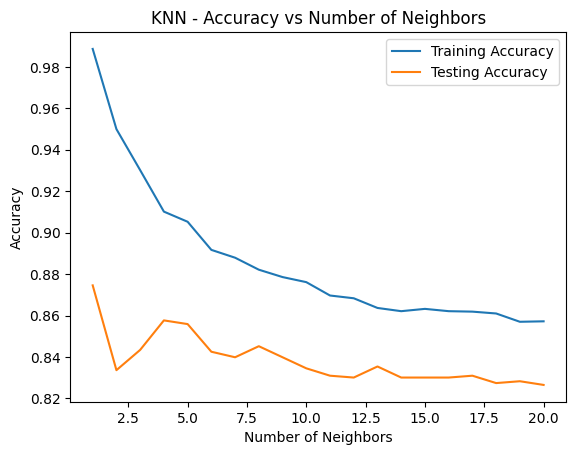

In [ ]:
plt.plot(neighbors_range, train_acc, label='Training Accuracy')
plt.plot(neighbors_range, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs Number of Neighbors')
plt.legend()
plt.show()

In [ ]:
# Classification Report (summary of main classification performance)
print("Classification Report:")
print(classification_report(y_test, knn_predictions, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.86      0.89       592
     Class 1       0.86      0.91      0.88       532

    accuracy                           0.89      1124
   macro avg       0.89      0.89      0.89      1124
weighted avg       0.89      0.89      0.89      1124



In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.8870106761565836


In [ ]:
# Precision
precision = precision_score(y_test, knn_predictions)
print("Precision Score:", precision)

Precision Score: 0.8584070796460177


In [ ]:
# F1 Score
f1 = f1_score(y_test, knn_predictions, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.8870904082491989


In [ ]:
# Recall Per Class
recall = recall_score(y_test, knn_predictions)
print("Recall Per Class:", recall)

Recall Per Class: 0.9116541353383458


In [ ]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, knn_predictions)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.8882595001016054


Confusion Matrix:
 [[512  80]
 [ 47 485]]


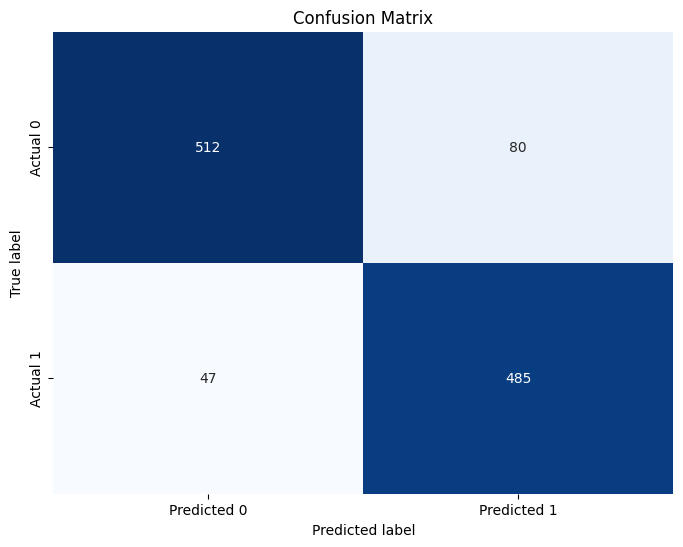

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, knn_predictions)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

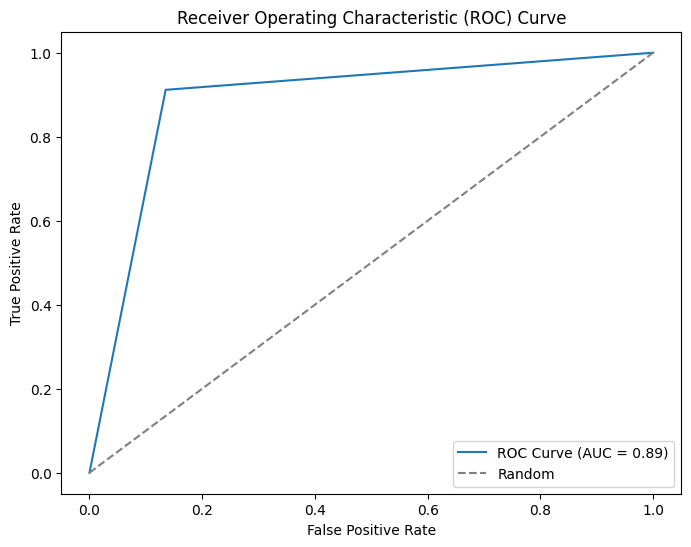

In [84]:
# ROC Curve
if len(np.unique(y_test)) == 2:
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_test, knn_predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [85]:
scaler = StandardScaler()
X_rescaled_nd = scaler.fit_transform (X_resampled)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_rescaled_nd, y_resampled, test_size=0.20, random_state=42)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.83      0.85       592
     Class 1       0.82      0.86      0.84       532

    accuracy                           0.85      1124
   macro avg       0.85      0.85      0.85      1124
weighted avg       0.85      0.85      0.85      1124

Accuracy Score: 0.8469750889679716
Precision Score: 0.8225806451612904
F1 Score: 0.8470822604763871
Recall Per Class: 0.8627819548872181
ROC-AUC Score: 0.8477761125787443
Confusion Matrix:
 [[493  99]
 [ 73 459]]


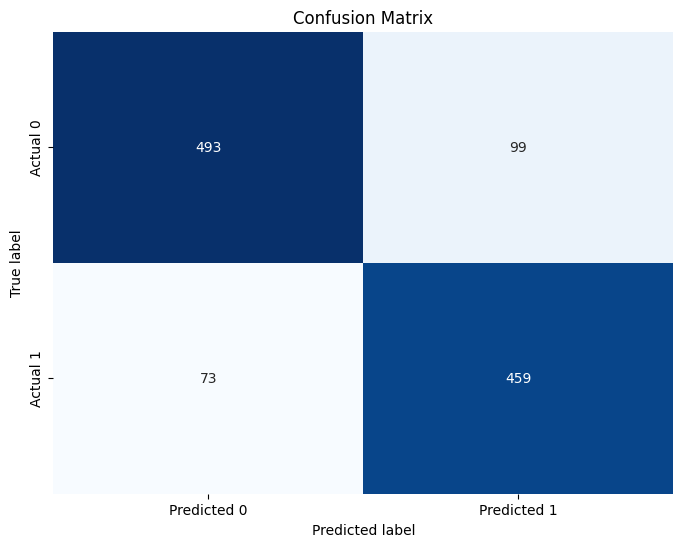

In [97]:
coral = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=20,)
coral.fit(X_train_nd, y_train_nd)

coral_prediction = coral.predict(X_test_nd)

print("Classification Report:")
print(classification_report(y_test_nd, coral_prediction, target_names=['Class 0', 'Class 1']))

accuracy = accuracy_score(y_test_nd, coral_prediction)
print("Accuracy Score:", accuracy)

precision = precision_score(y_test_nd, coral_prediction)
print("Precision Score:", precision)

f1 = f1_score(y_test_nd, coral_prediction, average='weighted')
print("F1 Score:", f1)

recall = recall_score(y_test_nd, coral_prediction)
print("Recall Per Class:", recall)

roc_auc = roc_auc_score(y_test_nd, coral_prediction)
print("ROC-AUC Score:", roc_auc)

conf_matrix = confusion_matrix(y_test_nd, coral_prediction)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# NAIVE BAYES

# SVM
## Linear
## Non Linear
